In [1]:
#examine differentiable histogram loss
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f = torch.nn.ReLU()
m = torch.nn.Tanh()

In [3]:
#define global constant
p = 20 #parallel runs
N = 5000 #steps per run
R = 31 #no. bins + 1
delta_t = 1e-3 #discretization of time
tau = 0.02 #membrane potential
hist_min = -2.0 #histogram range
hist_max = 2.0

In [4]:
def diff_hist_p1(s,N,p,R,hist_min,hist_max):
    #R: number of bins
    #delta: bin width
    #s: sample set (p runs, N samples each run)
    #p: parallel runs
    delta = (hist_max - hist_min)/(R-1)
    s = torch.reshape(s,(p,N,1))
    r = torch.linspace(1,R-2,R-2).repeat(p,N,1)
    T_r = hist_min + r*delta
    T_rm1 = hist_min + r*delta - delta
    T_rp1 = hist_min + r*delta + delta
    return f(torch.sum(f(s-T_rm1) - 2.0*f(s-T_r) + f(s - T_rp1), axis = 1)/(N*delta))

In [5]:
class network1():
    def forward(c,w,w_o):
        r = torch.randn(12,p)
        s = torch.zeros(p,N)
        for i in range(N*20):
            r = r + delta_t * (-r + m(w@r))/tau+ (2/tau)**0.5*delta_t**0.5*c@torch.randn(12,p)
            if i%20 == 0:
            #please add sub-sampling here to prevent W from going to unrealisticly large value and generate 1 sample
            #per time step
                s[:,i//20] = w_o@r
        return s
    
    def kl_loss(s,target_hist):
        sim_hist = diff_hist_p1(s,N,p,R,hist_min,hist_max)
        #hist_cost = torch.sum(torch.sum(target_hist*torch.log((target_hist + 1e-20)/(sim_hist + 1e-20)),axis = 1))
        #hist_cost_2 = torch.sum(torch.sum(sim_hist*torch.log((sim_hist + 1e-20)/(target_hist + 1e-20)),axis = 1))
        hist_cost = torch.sum(torch.sum(torch.abs(target_hist - sim_hist)))
        out_range_cost = torch.mean(f(hist_min-s)**2 + f(s-hist_max)**2)
        #return hist_cost + hist_cost_2 + 1000*out_range_cost
        return hist_cost + 1000*out_range_cost

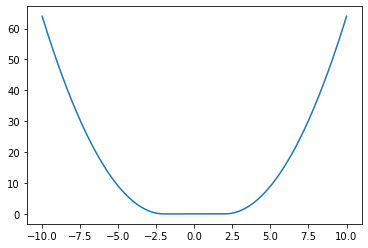

In [6]:
plt.plot(torch.linspace(-10,10,1000).detach(),f(hist_min-torch.linspace(-10,10,1000)).detach()**2 + f(torch.linspace(-10,10,1000)-hist_max).detach()**2)

In [7]:
'''t = np.arange(1,R-1)*(hist_max - hist_min)/(R-1) - hist_max
target_hist = 1/8**0.5/np.pi**0.5/mode_std*np.exp(-1/2/(mode_std)**2*(t-mode_loc[0])**2) + 1/8**0.5/np.pi**0.5/mode_std*np.exp(-1/2/(mode_std)**2*(t-mode_loc[1])**2)
target_hist = torch.tensor(target_hist/np.sum(target_hist))'''

't = np.arange(1,R-1)*(hist_max - hist_min)/(R-1) - hist_max\ntarget_hist = 1/8**0.5/np.pi**0.5/mode_std*np.exp(-1/2/(mode_std)**2*(t-mode_loc[0])**2) + 1/8**0.5/np.pi**0.5/mode_std*np.exp(-1/2/(mode_std)**2*(t-mode_loc[1])**2)\ntarget_hist = torch.tensor(target_hist/np.sum(target_hist))'

In [7]:
t = np.arange(1,R-1)*(hist_max - hist_min)/(R-1) - hist_max
target_hist = np.exp(-5*np.abs(t))
target_hist = torch.tensor(target_hist/np.sum(target_hist))

tensor(1.0000, dtype=torch.float64)


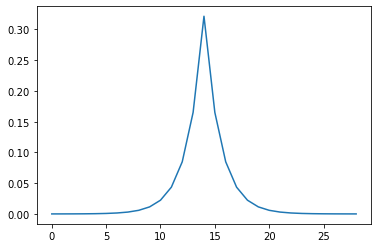

In [8]:
plt.plot(target_hist.numpy())
print(torch.sum(target_hist))

In [9]:
network1.kl_loss(torch.randn(20,5000)*0.2957,target_hist)

tensor(6.4926, dtype=torch.float64)

In [10]:
network1.kl_loss(torch.tensor(np.random.laplace(scale = 0.2, size = (20,5000))),target_hist)

tensor(2.1976, dtype=torch.float64)

In [11]:
'''max_eig = True
while max_eig:
    w = torch.autograd.Variable(torch.randn(8,8),requires_grad = True).float()
    if torch.max(torch.real((torch.linalg.eig(w.detach())[0])))<1:
        max_eig = False'''

w = torch.autograd.Variable(torch.randn(12,12),requires_grad = True).float()

c = torch.autograd.Variable(torch.randn(12,12),requires_grad = True).float()
w_o = torch.autograd.Variable(torch.randn(1,12),requires_grad = True).float()

In [12]:
import sys
loss_list = []
L = 0

optimizer = torch.optim.Adam([w,c,w_o], 0.02)

for v in range(100):
    optimizer.zero_grad()
    samples = network1.forward(c,w,w_o)
    L = network1.kl_loss(samples,target_hist)
    
    L1 = L.detach().numpy().copy()
    if v%5 == 0:
        print(L1)
    loss_list.append(L1)
    
    if np.isnan(L1) == True:
        print('error')
        sys.exit(0)
        
    L.backward()
    optimizer.step()

optimizer = torch.optim.Adam([w,c,w_o], 0.01) 
    
for v in range(150):
    optimizer.zero_grad()
    samples = network1.forward(c,w,w_o)
    L = network1.kl_loss(samples,target_hist)
    
    L1 = L.detach().numpy().copy()
    if v%5 == 0:
        print(L1)
    loss_list.append(L1)
    
    if np.isnan(L1) == True:
        print('error')
        sys.exit(0)
        
    L.backward()
    optimizer.step()

69868.1940221365
26205.54134312229
8979.15190950687
3083.562162136023
981.4050621826082
304.982583397034
124.42681884669081
71.01048024181591
49.8154782456936
38.43023550086216
31.717464304409727
27.47489843067543
25.68444647541873
24.493205181411167
23.49154088868858
23.055888802642986
22.423990407391504
22.34812785209255
22.146805980606988
22.00459359389828
21.677317296984658
17.16680514310469
13.822579099036632
10.865885619848477
7.767176849288225
5.751099019067574
5.237748216496321
4.984730196688626
4.781982414275928
4.643869238783944
4.471908368023351
4.051668436649075
3.8725873117335983
3.6878016817407744
3.437730957730511
3.2603228506043385
3.047720706427987
3.0732953636390077
2.8282316209342966
2.6533733707595992
2.4696424373289467
2.3552285633716474
2.2732123857705315
2.2008347923139384
2.133453341938585
2.0773263979639642
1.932760407170456
1.8226014707439573
1.7606404088593157


KeyboardInterrupt: 

1.734088354410819
243


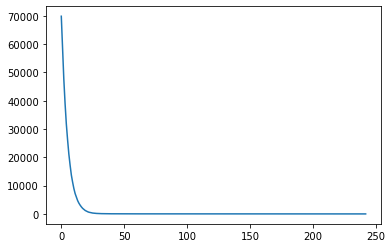

In [14]:
plt.plot(loss_list)
print(loss_list[-1])
print(len(loss_list))

In [15]:
s = network1.forward(c,w,w_o).detach()

In [16]:
s.shape

torch.Size([20, 5000])

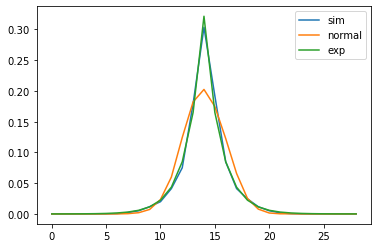

tensor(1.7797, dtype=torch.float64)


In [19]:
plt.plot(diff_hist_p1(s,N,p,R,hist_min,hist_max)[0])
plt.plot(diff_hist_p1(torch.randn(20,5000)*0.2530,N,p,R,hist_min,hist_max)[0])
plt.plot(target_hist)
plt.legend(['sim','normal','exp'])
plt.show()
print(network1.kl_loss(s,target_hist))

In [18]:
torch.std(s)

tensor(0.2530)

In [20]:
np.savetxt('w',w.detach().numpy())
np.savetxt('c',c.detach().numpy())
np.savetxt('w_o',w_o.detach().numpy())

In [22]:
w_o

tensor([[-0.5501, -0.0183,  0.2031,  0.1055,  0.0929,  0.5408,  0.3013, -0.1819,
          0.4251,  0.0963, -0.1693, -0.2170]], requires_grad=True)

In [23]:
import pickle
pickle.dump([w.detach().numpy(),c.detach().numpy(),w_o.detach().numpy()], open("exp.p", "wb"))